# My own deep learning framework

In the context of a course project during my PhD, I had to code my very own deep learning framework in pure Python. We were supposed to keep things simple and implement different modules (e.g. ReLU, Tanh etc.) linked sequentially, each with its own forward and backward pass. But I decided to spice things up a little and consider the whole network as a computational graph, using the [approach already used in TensorFlow](https://www.tensorflow.org/versions/r1.3/get_started/get_started#the_computational_graph). If you're not familiar with the basics of deep learning, before reading what's coming next, I heavily encourage you to have a look at the amazing [3Blue1Brown video tutorials on deep learning](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

Before anything, let's import some basic packages for computation and plotting, to make our life easier later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Purely aesthetics imports
import seaborn as sn
sn.set_style("white")

# High resolution plot
import matplotlib_inline.backend_inline as backend_inline 
backend_inline.set_matplotlib_formats('png2x')

## The Node class

The first thing we're going to do is to define a `Node`, which can be interpret as a layer of the network. It can be either a layer of parameters, either a given transformation (function like SoftMax or Tanh), either simply the input. Parameters nodes are given a value when instancied, while input and functions do not. The value of the input is given when computing the forward pass, and the value returned by each function in the graph is computed iteratively during the forward pass. 

In [2]:
class Node:
    """Define a node (input, operation (various types), or parameter) of the
       network.
    """
    def __init__(self, value = None, type = None, parents = []):
        """ Constructor:
            -value is a ndarray used to assign a value to
            the current node.
            -type is a string specifying the type of the node: 'input' as input,
            'par' as parameter, and 'add'/'dot' as operations.
            -parents is a list of nodes corresponding to the parents of the
            current node in the graph.
        """
        if type is None:
            if value is None:
                self.type = 'input'
            else:
                self.type = 'par'
        else:
            self.type = type
        if type == 'par' and value is None:
            raise ValueError('A parameter node must have a value')
        if type == 'input' and value is not None:
            raise ValueError("An input node can't have a value")
        self.value = value
        self.parents = parents
        self.children = set()
        self.dic_op = {'add' : self.compute_add,
                        'dot' : self.compute_dot,
                        'relu' : self.compute_relu,
                        'tanh' : self.compute_tanh}
        self.dic_d_op = {'add' : self.compute_d_add,
                        'dot' : self.compute_d_dot,
                        'relu' : self.compute_d_relu,
                        'tanh' : self.compute_d_tanh}
        self.grad = 0
        self.grad_computed = False


You can see that each node also come with several other attributes:
* `parents` is a list containing pointers toward the parent nodes. 
* `children` is a set containing pointers toward the children nodes. 
* `dic_op` is used only for function nodes, in which case it maps the name of the function to the corresponding implementation.
* `dic_d_op` is exactly the same thing as `dic_op`, except that it is used for the backward pass, therefore using the gradient of the functions.
* `grad` is a float accumulating the gradient during the backward pass.
* `grad_computed` is a boolean used to ensure that one doesn't compute twice the gradient of a given node during the backward pass.

We can then define all the common functions used in deep learning networks, as well as their gradient. Note that we don't implement any convolution here (it could be possible, but the gradient computation is a bit trickier).

In [3]:
class Node(Node):
    def add(self, node):
        """Function to create a new node whose value is the addition of the two
            parents. Self node must be a parameter, 'node' node can be of any
            type.
        """
        if node.type=='par':
            raise ValueError("Self node must be a parameter")
        child = Node(type = 'add', parents = [self,node])
        self.children.add(child)
        node.children.add(child)
        return child

    def compute_add(self):
        """Function to compute the addition of the values of the two parents.
        """
        return np.add(*[parent.value for parent in self.parents])

    def compute_d_add(self, grad):
        """Function to compute the derivative of the addition of the values of
            the two parents.
        """
        return 1*grad

    def dot(self, node):
        """Function to create a new node which is the dot product of the values
            of the two parents.Self node must be a parameter, 'node' node can be
            of any type.
        """
        if node.type=='par':
            raise ValueError("Self node must be a parameter")
        child = Node(type = 'dot', parents = [self,node])
        self.children.add(child)
        node.children.add(child)
        return child

    def compute_dot(self):
        """Function to compute the dot product between the parent 1 (w) and
            the parent 2 (x).
        """
        return np.dot(self.parents[0].value,self.parents[1].value.T).T

    def compute_d_dot(self, grad):
        """Function to compute the derivative of the dot product between
            parent 1 (w) and parent 2 (x).
        """
        return np.dot(self.parents[0].value.T, grad.T ).T

    def relu(self):
        """Function to create a new node which is relu of the parent node value.
        """
        child = Node(type = 'relu', parents = [self])
        self.children.add(child)
        return child

    def compute_relu(self):
        """Function to compute the value of the current node using relu function
            on the parent node.
        """
        if len(self.parents)>1:
            raise ValueError('reLu takes only a single parent as input')
        return self.parents[0].value * (self.parents[0].value > 0)

    def compute_d_relu(self, grad):
        """Function to compute the gradient of the current node using relu
            function on the parent node.
        """
        if len(self.parents)>1:
            raise ValueError('reLu takes only a single parent as input')
        return (1 * (self.parents[0].value > 0))*grad

    def tanh(self):
        """Function to create a new node which is tanh of the parent node value.
        """
        child = Node(type = 'tanh', parents = [self])
        self.children.add(child)
        return child

    def compute_tanh(self):
        """Function to compute the value of the current node using tanh function
            on the parent node.
        """
        if len(self.parents)>1:
            raise ValueError('tanh takes only a single parent as input')
        return np.tanh(self.parents[0].value )

    def compute_d_tanh(self, grad):
        """Function to compute the gradient of the current node using tanh
            function on the parent node.
        """
        if len(self.parents)>1:
            raise ValueError('tanh takes only a single parent as input')
        return (1-np.tanh(self.parents[0].value)**2)*grad

Now that we have all the functions implemented, we can implement the forward pass. Starting from the end node, the principle is simply to compute recurrently the value of all nodes, by using the value of their parent node(s) as input(s) to the function of the current node.

In [4]:
class Node(Node):
    def compute_forward(self):
        """Compute the values of the complete graph in a forward manner.
        """
        def assert_parents(parents):
            for parent in parents:
                if parent.value is None:
                    return False
            return True

        def compute_nodes_value(current_node):
            for parent in current_node.parents:
                compute_nodes_value(parent)
            if current_node.type!='par' and current_node.type!='input':
                if assert_parents(current_node.parents):
                    current_node.value = current_node.dic_op[current_node.type]()
                else:
                    raise ValueError('A bug occured somewhere in the forward pass')

        compute_nodes_value(self)

We can then do the same thing for the backward pass, taking advantage of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). Things are getting a little bit more trickier here, but the principle is simply to start from the gradient of the loss computed on the end node, and to backpropagate iteratively to the first node. In order to be sure I don't compute the gradient twice for a given node, I always check that the `grad_computed` is set to `False` before running any computation.  

In [5]:
class Node(Node):
    def compute_backward(self, d_loss):
        """Compute the gradient of the complete graph in a backward manner.
        """
        def assess_children(children):
            for child in children:
                if not child.grad_computed:
                    return False
            return True

        def compute_grad_value(current_node, child = None):
            if child is None:
                current_node.grad =  self.dic_d_op[current_node.type](d_loss)
                current_node.grad_computed = True
            else:
                if child.grad_computed:
                    if current_node.type=='input':
                        current_node.grad += child.grad
                    elif current_node.type=='par':
                        if child.type == 'add':
                            current_node.grad += np.sum(child.grad, axis = 0)
                        if child.type == 'dot':
                            if len(child.children)==1:
                                child_children = next(iter(child.children))
                                current_node.grad += np.dot(child_children.grad.T, child.parents[1].value)
                            else:
                                child_grad = np.sum([c.grad for c in child.children], axis = 0)
                                current_node.grad += np.dot( child_grad.T, child.parents[1].value)
                    else:
                        current_node.grad += current_node.dic_d_op[current_node.type](child.grad)
                else:
                    raise ValueError('A bug occured somewhere in the backward pass')
                current_node.grad_computed = assess_children(self.children)

            if current_node.grad_computed:
                for parent in current_node.parents:
                    compute_grad_value(parent, child = current_node)

        compute_grad_value(self)

We can now create nodes (layers), but we still haven't defined any gradient descent algorithm, nor any loss... This will be done in the `Network` class, that we're going to implement right now.


## The Network class
This class contains no argument but the output node of the network one wants to build.

In [6]:
class Network:
    """Contains all the nodes (layers) of the network.
    """
    def __init__(self, output_node = Node()):
        """ Constructor:
            -output_node must correspond to the last node of the previously
             built dynamical graph.
        """
        self.output_node = output_node
        self.input_node = self.find_input_node()
        self.s_parameter_nodes = set()

The input node is then found automatically by browsing the graph in an ascending manner. 

In [7]:
class Network(Network):
    def find_input_node(self):
        """ Function to find the node corresponding to the first layer of the
            dynamical graph using recursion.
        """
        set_input = set()

        def look_parent(current_node):
            for parent in current_node.parents:
                if parent.type=='input':
                    set_input.add(parent)
                look_parent(parent)

        look_parent(self.output_node)
        if len(set_input)>1:
            raise ValueError("There can only be one input to this graph.")
        else:
            return set_input.pop()

The function to compute the foward pass is then nothing more than a wrapper of the same function in the `Node` class.

In [8]:
class Network(Network):
    def do_forward(self, input):
        """ Do the forward pass:
            -input must be a FloatTensor or DoubleTensor. It is with this tensor
            that we feed the network.
        """
        self.input_node.value = input
        self.output_node.compute_forward()
        return self.output_node.value

In preparation for the computation of the backward pass, we can now define the loss and its derivative. For now, we stick to a simple Mean-Squared error loss, but it wouldn't be complicated to do the same thing with, for instance, a cross-entropy loss. If you're interested, have a look at this [really good article](http://rohanvarma.me/Loss-Functions/) about the different types of losses and when to use them.

In [9]:
class Network(Network):    
    def MSE_loss(self, target):
        """ Compute the Mean Squared Error (MSE) loss of the network.
            -target must be a FloatTensor or DoubleTensor of the same size as
            the ouput layer.
        """
        if self.output_node.value is not None:
            return 1/len(self.output_node.value)\
                    *np.sum((self.output_node.value-target)**2)
        else:
            raise ValueError("The loss can only be computed after having done \
                                the forward pass.")

    def d_MSE_loss(self, target):
        """ Compute the derivative of the Mean Squared Error (MSE) loss of the
            network.
            -target must be a FloatTensor or DoubleTensor of the same size as
            the ouput layer.
        """
        if self.output_node.value is not None:
            return 2*(self.output_node.value-target)
        else:
            raise ValueError("The loss derivative can only be computed after \
                                having done the forward pass")

We can now implement the wrapper for the backward pass, which takes as input both the target vector and the type of the loss.

In [10]:
class Network(Network):    
    def do_backward(self, target, type_loss):
        """ Do the backward pass:
            -target must be a FloatTensor or DoubleTensor of the same size as
            the ouput layer.
            -type_loss sets the type of loss function implemented. Only Mean
            Squared Error (MSE) is available for now.
        """
        if type_loss == "MSE":
            d_loss = self.d_MSE_loss(target)
            grad = self.output_node.compute_backward(d_loss)
        else:
            raise ValueError("Only MSE loss is implemented for now.")

And as an optimization algorithm, we're going to implement the vanilla stochastic SGD. Since we first need to know which nodes are correspond to layers of parameters before optimizing them, we're also going to make a quick search through the graph before running the SGD itself. Also, we need to ensure every boolean flag telling us if the gradient has already been computed is set to `False` *before* doing the SGD, so we're going to define a function for that. In the end, we get:

In [11]:
class Network(Network):    
    def find_parameter_nodes(self):
        """ Function to find and add in a set the parameters node of the graph.
        """
        def find_parameter(current_node):
            for parent in current_node.parents:
                if parent.type=='par':
                    self.s_parameter_nodes.add(parent)
                else:
                    find_parameter(parent)
        find_parameter(self.output_node)
        
    def reset_flags(self):
        """ Function to reset the gradients and the corresponding flags of all
            the nodes of the network.
        """
        def reset_flag(current_node):
            for parent in current_node.parents:
                parent.grad_computed = False
                parent.grad =0.
                reset_flag(parent)

        self.output_node.grad_computed = False
        self.output_node.grad = 0.
        reset_flag(self.output_node)
        
    def do_SGD(self, input, target, type_loss = "MSE", n_iter = 1000, eta = 0.1,
                size_batch = 50, verbose = False, plot = False):
        """ Do the Stochastic Gradient Descent (SGD) to optimize the parameters
            of the graph:
            -input must be a FloatTensor or DoubleTensor. It is with this tensor
            that we feed the network.
            -target must be a FloatTensor or DoubleTensor of the same size as
            the ouput layer.
            -type_loss sets the type of loss function implemented. Only Mean
            Squared Error (MSE) is available for nowself.
            -n_iter is an integer specifying the number of SGD iterations.
            -eta is a float specifying the the size of the linear expansion used
            to compute the gradient.
            -verbose is a bool specifying is the MSE loss must be printed at
            each iteration.
        """
        self.find_parameter_nodes()
        l_error = []
        n_subiter = int(len(input)/size_batch)
        batched_input = [input[k2*size_batch:(k2+1)*size_batch,:] for k2 in range(n_subiter)]
        batched_target = [target[k2*size_batch:(k2+1)*size_batch,:] for k2 in range(n_subiter)]
        tot_iter = 0
        for k in range(n_iter):
            for sample, target_sample in zip(batched_input, batched_target):
                self.do_forward(sample)
                self.do_backward(target_sample, type_loss)
                for node in self.s_parameter_nodes:
                    node.value -= eta * node.grad
                self.reset_flags()
                l_error.append(float(self.MSE_loss(target_sample)))
                tot_iter += 1
            if verbose:
                print('it ' + str(k)+': '+ str(float(self.MSE_loss(target_sample))))
        if plot:
            plt.figure(figsize=(8,8))
            plt.plot(np.linspace(0,n_iter,tot_iter, endpoint = True), l_error)
            plt.xscale('log', basex=10)
            plt.xlabel("Iteration")
            plt.ylabel('MSE error')
            plt.title('Evolution of the error (train)')
            plt.show()
            plt.close()

And that's it, our Network class is now over! Let's see how well it works in practice.

## Running the network

Training started... It should take less than a minute.
Training done
MSE on train set:  0.03390689695683746
MSE on test set:  0.05046097516812831


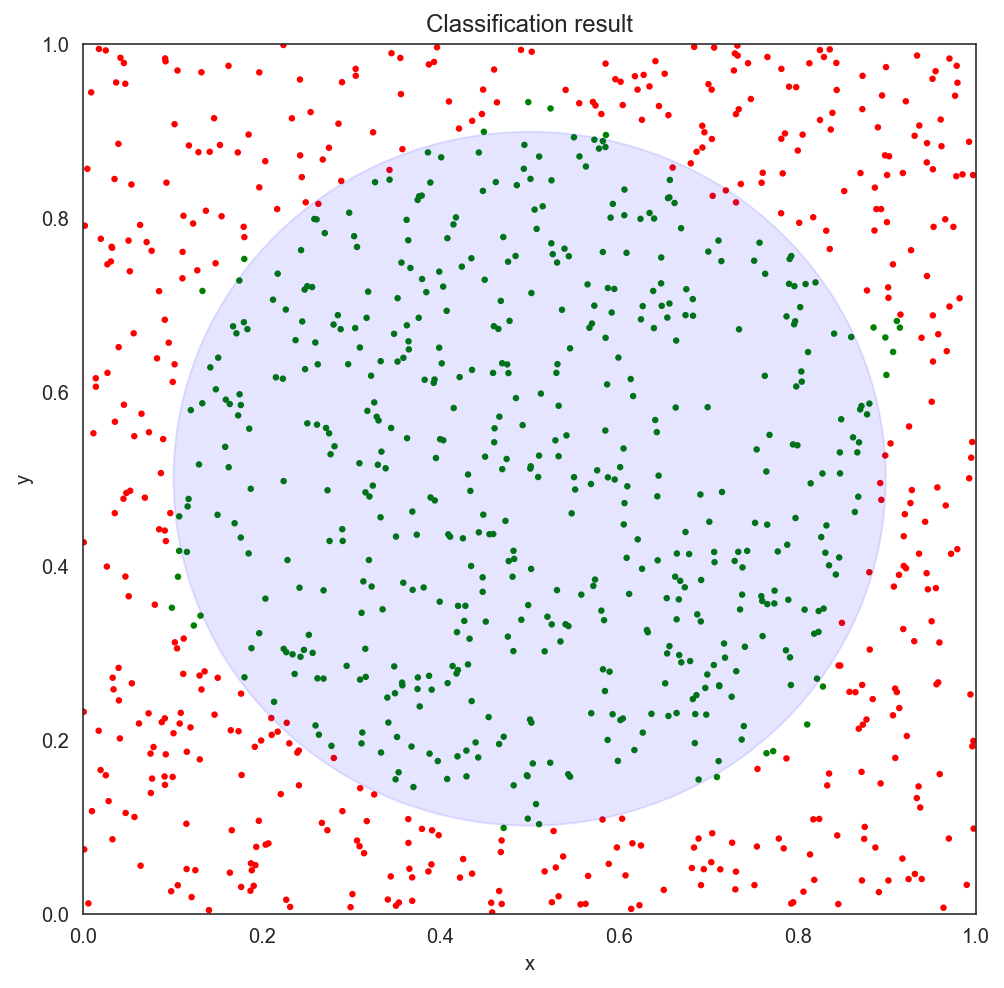

In [12]:
""" Create train and test sets """
train_set = np.random.rand(1000,2)
train_target = np.array([(0,1) if ( (x1-0.5)**2+(x2-0.5)**2)**0.5>1/(2*np.pi)**0.5 \
                        else (1,0) for (x1,x2) in train_set])

test_set = np.random.rand(1000,2)
test_target = np.array([(0,1) if ( (x1-0.5)**2+(x2-0.5)**2)**0.5>1/(2*np.pi)**0.5 \
                        else (1,0) for (x1,x2) in test_set])

nb_classes = train_set.shape[1]
nb_train_samples = train_set.shape[0]

""" Set meta-parameters """
nb_hidden = 25
eta = 1e-1 / nb_train_samples
epsilon = 1e-1

""" Create tensors of parameters for the network """
w1_tensor = np.random.randn(nb_hidden, train_set.shape[1])*epsilon
b1_tensor = np.random.randn(nb_hidden)*epsilon

w2_tensor = np.random.randn(nb_hidden, nb_hidden)*epsilon
b2_tensor = np.random.randn(nb_hidden)*epsilon

w3_tensor = np.random.randn(nb_classes, nb_hidden)*epsilon
b3_tensor = np.random.randn(nb_classes)*epsilon

""" Create computation graph (network) """
x0 = Node()
s1 = Node(b1_tensor).add( Node(w1_tensor).dot(x0) )
x1 = s1.relu()
s2 = Node(b2_tensor).add(Node(w2_tensor).dot(x1))
x2 = s2.relu()
s3 = Node(b3_tensor).add(Node(w3_tensor).dot(x2))
x3 = s3.tanh()

N = Network(x3)

""" Train the network """
print('Training started... It should take less than a minute.')
N.do_SGD(train_set, train_target, type_loss = "MSE", n_iter = 10000, eta = eta,
        size_batch = 100, verbose = False, plot = False)
print('Training done')

""" Print final train error """
N.do_forward(train_set)
print('MSE on train set: ', float(N.MSE_loss(train_target)))

""" Print test error """
N.do_forward(test_set)
print('MSE on test set: ', float(N.MSE_loss(test_target)))

""" Plot the result """
l_color = ['r' if np.argmax(r)==1 else 'g' for r,t in zip(N.output_node.value, test_target)]
circle = plt.Circle((0.5, 0.5), 1/(2*np.pi)**0.5, color='b', alpha = 0.1)
fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(circle)
plt.scatter(np.array(test_set[:,0]), np.array(test_set[:,1]), c = l_color, s = 5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Classification result')
plt.show()
plt.close()

That was a little bit of work, but I believe that's the only way to really understand what actually happens in the network. Plus the result is really cool!